# DCGAN - 블록 데이터

- 레고 블록 이미지 40,000장 모아놓음

In [1]:
import sys

if 'google.colab' in sys.modules :
  !wget https://raw.githubusercontent.com/rickiepark/Generative_Deep_Learning_2nd_Edition/main/notebooks/utils.py
  !mkdir -p notebooks
  !mv utils.py notebooks


--2024-10-06 05:46:41--  https://raw.githubusercontent.com/rickiepark/Generative_Deep_Learning_2nd_Edition/main/notebooks/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 771 [text/plain]
Saving to: ‘utils.py’

utils.py            100%[===================>]     771  --.-KB/s    in 0s      

2024-10-06 05:46:41 (29.2 MB/s) - ‘utils.py’ saved [771/771]



In [2]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import (
    layers,
    models,
    callbacks,
    losses,
    utils,
    metrics,
    optimizers,
)

from notebooks.utils import display, sample_batch

## 0. 파라미터

In [4]:
IMAGE_SIZE = 64
CHANNELS = 1
BATCH_SIZE = 128
Z_DIM = 100
EPOCHS = 100 # 훈련이 오래 걸려 에포크 횟수를 300에서 100으로 줄입니다.
LOAD_MODEL = False
ADAM_BETA_1 = 0.5
ADAM_BETA_2 = 0.999
LEARNING_RATE = 0.0002
NOISE_PARAM = 0.1

## 1. 데이터 준비

In [6]:
# 코랩일 경우 노트북에서 celeba 데이터셋을 받습니다.
if 'google.colab' in sys.modules:
    # # 캐글-->Setttings-->API-->Create New Token에서
    # # kaggle.json 파일을 만들어 코랩에 업로드하세요.
    # from google.colab import files
    # files.upload()
    # !mkdir ~/.kaggle
    # !cp kaggle.json ~/.kaggle/
    # !chmod 600 ~/.kaggle/kaggle.json
    # # celeba 데이터셋을 다운로드하고 압축을 해제합니다.
    # !kaggle datasets download -d joosthazelzet/lego-brick-images
    #
    # 캐글에서 다운로드가 안 될 경우 역자의 드라이브에서 다운로드할 수 있습니다.
    import gdown
    gdown.download(id='1qd50QDZtr_NYFiFVdp0sIvGDwTT3mMEQ')
    !unzip -q lego-brick-images.zip
    # output 디렉토리를 만듭니다.
    !mkdir output

Downloading...
From (original): https://drive.google.com/uc?id=1qd50QDZtr_NYFiFVdp0sIvGDwTT3mMEQ
From (redirected): https://drive.google.com/uc?id=1qd50QDZtr_NYFiFVdp0sIvGDwTT3mMEQ&confirm=t&uuid=de47da74-4e81-4dbc-b198-5e30e20cd1b0
To: /content/lego-brick-images.zip

  0%|          | 0.00/1.07G [00:00<?, ?B/s]
  2%|▏         | 16.8M/1.07G [00:00<00:06, 165MB/s]
  3%|▎         | 33.6M/1.07G [00:01<00:51, 20.0MB/s]
  4%|▍         | 42.5M/1.07G [00:01<00:39, 26.0MB/s]
  5%|▍         | 50.3M/1.07G [00:02<00:53, 19.2MB/s]
  6%|▌         | 61.3M/1.07G [00:02<00:50, 19.9MB/s]
  6%|▌         | 65.5M/1.07G [00:02<00:49, 20.3MB/s]
  7%|▋         | 73.9M/1.07G [00:03<00:37, 26.4MB/s]
  8%|▊         | 86.5M/1.07G [00:04<00:54, 17.9MB/s]
 10%|█         | 109M/1.07G [00:04<00:28, 33.2MB/s] 
 11%|█         | 118M/1.07G [00:05<00:46, 20.7MB/s]
 12%|█▏        | 132M/1.07G [00:05<00:32, 28.5MB/s]
 13%|█▎        | 141M/1.07G [00:06<00:41, 22.3MB/s]
 14%|█▍        | 154M/1.07G [00:06<00:42, 21.3MB/s]
 15

In [7]:
train_data = utils.image_dataset_from_directory(
    "./dataset/",
    labels=None,
    color_mode="grayscale",
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    interpolation="bilinear",
)

Found 40000 files.


- 원본 데이터는 [0, 255] 범위로 픽셀 강도 나타냄
- GAN을 훈련할 때 데이터를 [-1, 1] 범위로 스케일 재조정
- => 시그모이드 함수보다 더 강한 그레이디언트를 제공하는 tanh 활성화 함수를 사용하기 위해

In [8]:

def preprocess(img):
    """
    이미지 정규화 및 크기 변경
    """
    img = (tf.cast(img, "float32") - 127.5) / 127.5
    return img


train = train_data.map(lambda x: preprocess(x))

In [9]:
train_sample = sample_batch(train)

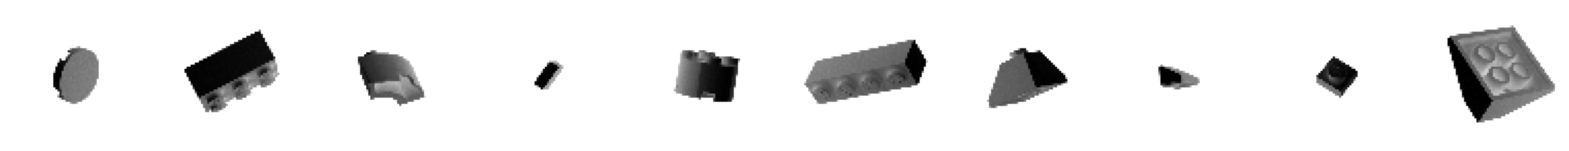

In [10]:
display(train_sample)

## 2. GAN 구축

In [11]:
# 판별자
discriminator_input = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS)) #판별자의 Input(이미지) 층을 정의함

# Conv2D층을 쌓고 그 사이에 BatchNormalization, LeakyReLU, Dropout층을 둔다
# 첫 번째 Conv2D층
x = layers.Conv2D(64, kernel_size=4, strides=2, padding="same", use_bias=False)(discriminator_input)
# 64개 필터 사용, 4X4 커널 사이즈 적용, 이미지의 크기는 절반, 입력과 출력이 같게 패딩, 바이어스 사용 X
x = layers.LeakyReLU(0.2)(x) # 활성화 함수로 LeakyReLU 적용해 음수 영역의 기울기 소멸 문제 해결 (음수에 0.2배만큼 기울기 부여)
x = layers.Dropout(0.3)(x) # Dropout층으로 학습 시 30% 노드를 무작위로 비활성화 => 과적합 방지

# 두 번째 층 Conv2D층
x = layers.Conv2D(128, kernel_size=4, strides=2, padding="same", use_bias=False)(x) # 128개 필터 사용
# BatchNormalization : 학습 속도를 높이고 안정성 향상을 위해 배치 정규화 적용
x = layers.BatchNormalization(momentum=0.9)(x)  # momentum = 0.9 : 이동 평균을 계산할 때 사용하는 모멘텀 값
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)

# 세 번째 Conv2D층
x = layers.Conv2D(256, kernel_size=4, strides=2, padding="same", use_bias=False)(x) # 256개 필터
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)

# 네 번째 Conv2D층
x = layers.Conv2D(512, kernel_size=4, strides=2, padding="same", use_bias=False)(x) # 512개 필터 => 이미지의 특징을 더 깊이 추출하는 역할
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)

# 마지막 Conv2D층
x = layers.Conv2D(
    1, # 필터 1개 사용
    kernel_size=4,
    strides=1,
    padding="valid",
    use_bias=False,
    activation="sigmoid", # 시그모이드 활성화 함수를 통해 0, 1 사이의 값 출력 => 판별자가 진짜 이미지/ 가짜 이미지 판별하는 역할
)(x)

discriminator_output = layers.Flatten()(x) # Flatten층으로 출력 텐서를 1차원으로 펼침 => 최종적인 출력값 얻기

discriminator = models.Model(discriminator_input, discriminator_output) # 판별자 모델 만들기 => 0, 1 사이의 숫자 하나 출력
discriminator.summary() # 모델 구조 요약해서 출력

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 64, 64, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 32, 32, 64)          │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 16, 16, 128)         │         131,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 8, 8, 256)           │         524,288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 8, 8, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 4, 4, 512)           │       2,097,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 4, 4, 512)           │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 1, 1, 1)             │           8,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,765,312 (10.55 MB)

 Trainable params: 2,763,520 (10.54 MB)

 Non-trainable params: 1,792 (7.00 KB)

- Conv2D 층에 스트라이드 2 지정 = 텐서가 네트워크를 통과하면서 공간 방향 크기가 줄어듧
- 64, 32, 18, 8, 4, 1로 줄어듦
- 채널 수(1, 64, 128, 256, 512로 증가)

In [12]:
# 생성자
# 생성자의 입력 = 다변량 표준 정규 분포에서 뽑은 벡터
# 출력 = 원본 훈련 데이터에 있는 이미지와 동일한 크기의 이미지

generator_input = layers.Input(shape=(Z_DIM,)) # Z_DIM 크기의 입력 벡터를 생정자의 입력으로 받음 / 보톤 노이즈로 랜덤한 값에서 시작해 가짜 데이터 생성
x = layers.Reshape((1, 1, Z_DIM))(generator_input) # 1X1 크기의 Z_DIM 채널을 가진 텐서로 입력 벡터를 변환

# Conv2DTranspose : 역전파 합성곱을 수행하는 층 => 이미지의 크기를 늘리며 정보 보존
# 첫 번째 역전파 합성곱 층
x = layers.Conv2DTranspose(
    512, kernel_size=4, strides=1, padding="valid", use_bias=False
)(x) # 필터 512개, 4X4 크기의 커널, 출력 크기 유지하고 패딩 사용 X
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)

# 두 번째 역전파 합성곱 층
x = layers.Conv2DTranspose(
    256, kernel_size=4, strides=2, padding="same", use_bias=False
)(x) # 필터 256개, 이미지의 크기 2배로 확장, 입력과 출력 크기 동일하게 패딩
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)

# 세 번째 역전파 합성곱 층
x = layers.Conv2DTranspose(
    128, kernel_size=4, strides=2, padding="same", use_bias=False
)(x) # 128개 필터 사용
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)

# 네 번째 역전파 합성곱 층
x = layers.Conv2DTranspose(
    64, kernel_size=4, strides=2, padding="same", use_bias=False
)(x) # 64개 필터 사용
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)

# 마지막 층
generator_output = layers.Conv2DTranspose(
    CHANNELS, # 생성된 이미지의 채널 수 (흑백 1 / 컬러 3)
    kernel_size=4,
    strides=2, # 이미지 크기를 2배로 늘리고
    padding="same",
    use_bias=False,
    activation="tanh", # tanh 활성화 함수를 사용해 생성된 이미지의 픽셀 값이 -1, 1 사이로 정규화
)(x)

#생성자 모델 정의
generator = models.Model(generator_input, generator_output)

# 생성자의 구조 요약 & 출력
generator.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 1, 1, 100)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 4, 4, 512)           │         819,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 4, 4, 512)           │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 8, 8, 256)           │       2,097,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 8, 8, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_5 (LeakyReLU)            │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 16, 16, 128)         │         524,288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_6 (LeakyReLU)            │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_3 (Conv2DTranspose) │ (None, 32, 32, 64)          │         131,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_7 (LeakyReLU)            │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_4 (Conv2DTranspose) │ (None, 64, 64, 1)           │           1,024 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,576,576 (13.64 MB)

 Trainable params: 3,574,656 (13.64 MB)

 Non-trainable params: 1,920 (7.50 KB)

- Conv2DTranspose ( 전차 합성곱 층 )
- => 출력 이미지 경계에 계단 모양이나 작은 체크무늬 패턴을 만들어 출력 품질을 떨어뜨린다고 알려짐

- Upsampling2D + Conv2D / Conv2DTranspose
- => 모두 원본 이미지 차원으로 되돌리는 데 사용할 수 있는 변환 방법

- **DCGAN 훈련**
- => 훈련 세트의 진짜 샘플과 생성자의 출력을 합쳐 훈련 세트를 만들어 판별자를 훈련 (지도학습)
- => 진짜 이미지 레이블 1 / 가짜 이미지 레이블 0 / 손실함수 : 이진 크로스 엔트로피 사용



- **생성자 훈련**
- => 생성된 이미지에 점수를 부여하고 높은 점수를 낸 이미지로 최적화하는 방법 ( 판별자의 역할 )
- 손실함수 : 모델의 출력 확률과 값이 1인 벡터 사이의 이진 크로스 엔트로피



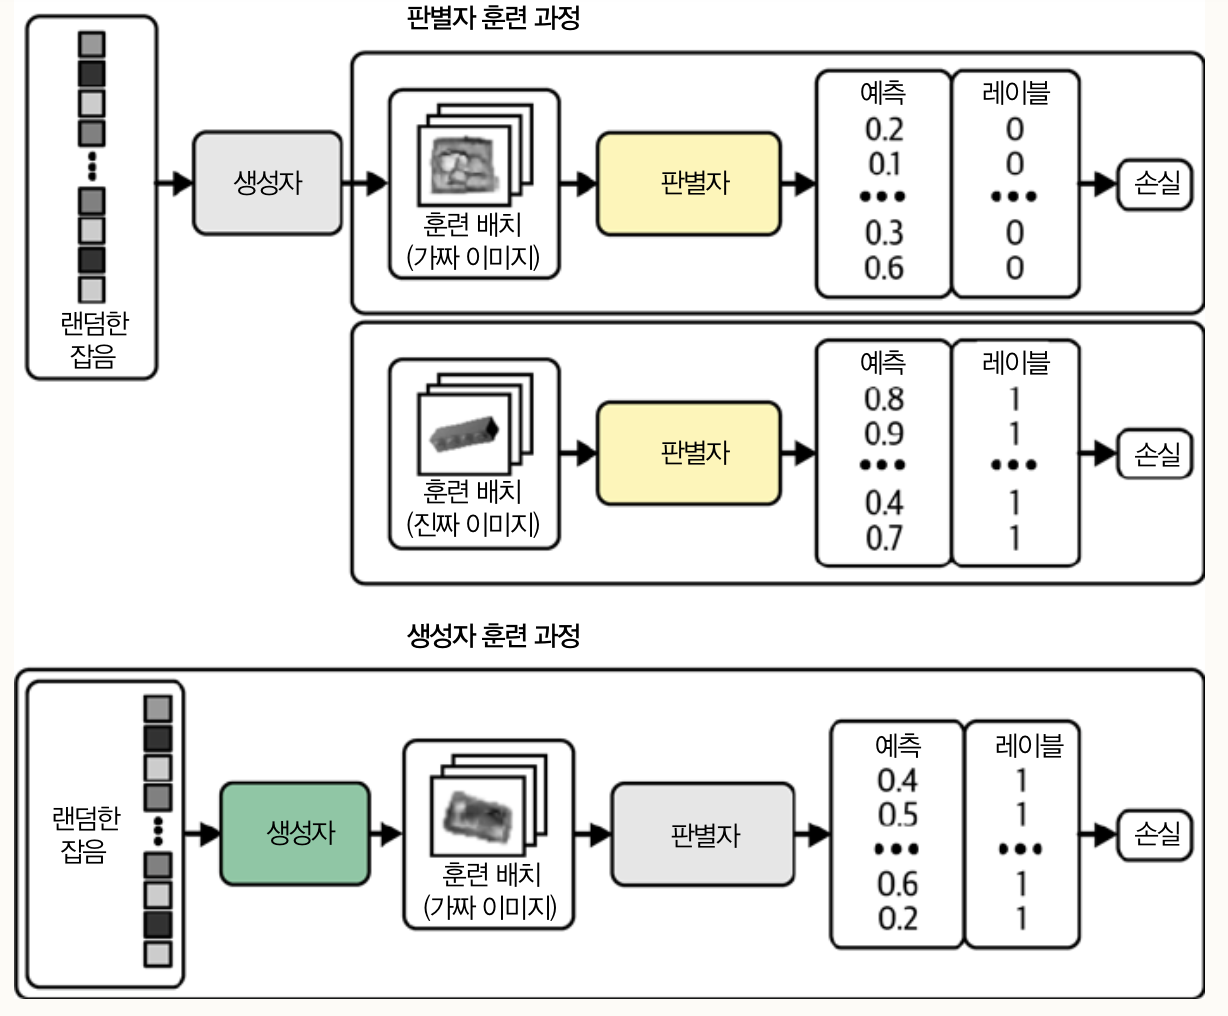

In [13]:
# DCGAN 모델 클래스 (생성자와 판별자가 상호 경쟁하며 학습하는 구조)

class DCGAN(models.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(DCGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim


    def compile(self, d_optimizer, g_optimizer):
        super(DCGAN, self).compile() # compile() : 모델을 학습할 준비
        self.loss_fn = losses.BinaryCrossentropy()# 손실함수 정의
        self.d_optimizer = d_optimizer # 최적화 함수 정의
        self.g_optimizer = g_optimizer # 최적화 함수 정의
        # metric으로 손실과 정확도를 사용해 성능 추적
        self.d_loss_metric = metrics.Mean(name="d_loss") # 손실
        self.d_real_acc_metric = metrics.BinaryAccuracy(name="d_real_acc") # 정확도
        self.d_fake_acc_metric = metrics.BinaryAccuracy(name="d_fake_acc") # 정확도
        self.d_acc_metric = metrics.BinaryAccuracy(name="d_acc") # 정확도
        self.g_loss_metric = metrics.Mean(name="g_loss") # 손실
        self.g_acc_metric = metrics.BinaryAccuracy(name="g_acc") # 정확도

    @property
    def metrics(self): # DCGAN 학습 중에 사용할 메트릭 반환 : 모델 학습 중에 성능 모니터링
        return [
                self.d_loss_metric,
                self.d_real_acc_metric,
                self.d_fake_acc_metric,
                self.d_acc_metric,
                self.g_loss_metric,
                self.g_acc_metric, ]

    def train_step(self, real_images): # 생성자와 판별자가 학습되도록 함
        # 잠재 공간에서 랜덤 포인트 샘플링
        # 잠재 공간에서 랜덤한 노이즈 벡터를 생성해 가짜 이미지를 만들고 이 이미지로 판별자 훈련
        batch_size = tf.shape(real_images)[0] # 실제 이미지의 배치 크기를 기반으로 잠재공간에서 무작위로 노이즈 벡터를 샘플링
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))


    # 가짜 이미지로 판별자 훈련하기
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
          generated_images = self.generator(
                random_latent_vectors, training=True
            ) # 생성자 : 노이즈 벡터를 받아 가짜 이미지 생성
          real_predictions = self.discriminator(real_images, training=True) # 판별자 : 진짜 이미지를 입력 받아 평가
          fake_predictions = self.discriminator(
                generated_images, training=True
            ) # 판별자 : 가짜 이미지를 입력 받아 평가

          # 레이블 정의 (노이즈 추가)
          real_labels = tf.ones_like(real_predictions) # 진짜 이미지 나타내는 레이블 : 1
          real_noisy_labels = real_labels + NOISE_PARAM * tf.random.uniform(
                tf.shape(real_predictions)
            ) # 레이블에 노이즈를 추가해 판별자를 더욱 견고하게 학습

          fake_labels = tf.zeros_like(fake_predictions) # 가짜 이미지 나타내는 레이블 : 0
          fake_noisy_labels = fake_labels - NOISE_PARAM * tf.random.uniform(
                tf.shape(fake_predictions)
            )

          d_real_loss = self.loss_fn(real_noisy_labels, real_predictions)
          d_fake_loss = self.loss_fn(fake_noisy_labels, fake_predictions)

          d_loss = (d_real_loss + d_fake_loss) / 2.0 # 판별자 손실 : 진짜와 가짜 이미지를 얼마나 잘 구분했는가
          g_loss = self.loss_fn(real_labels, fake_predictions) # 생성자 손실 : 가짜 이미지를 판별자가 진짜라고 믿게 만든 정도

          # GradientTape : 판별자와 생성자의 그레디언트 계산 후, 최적화 함수
          # optimizer : 각각의 파라미터를 업데이트
          gradients_of_discriminator = disc_tape.gradient(
            d_loss, self.discriminator.trainable_variables)
          gradients_of_generator = gen_tape.gradient(
              g_loss, self.generator.trainable_variables)

          self.d_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
          self.g_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))

          # 각 스텝마다 손실과 정확도를 추적하기 위해 정의된 메트릭을 업데이트
          self.d_loss_metric.update_state(d_loss)
          self.d_real_acc_metric.update_state(real_labels, real_predictions)
          self.d_fake_acc_metric.update_state(fake_labels, fake_predictions)
          self.d_acc_metric.update_state([real_labels, fake_labels], [real_predictions, fake_predictions])
          self.g_loss_metric.update_state(g_loss)
          self.g_acc_metric.update_state(real_labels, fake_predictions)

          # 업데이트 된 메트릭 값 반환 => 훈련 과정에서 성능 평가하는 데 사용
          return {m.name: m.result() for m in self.metrics}


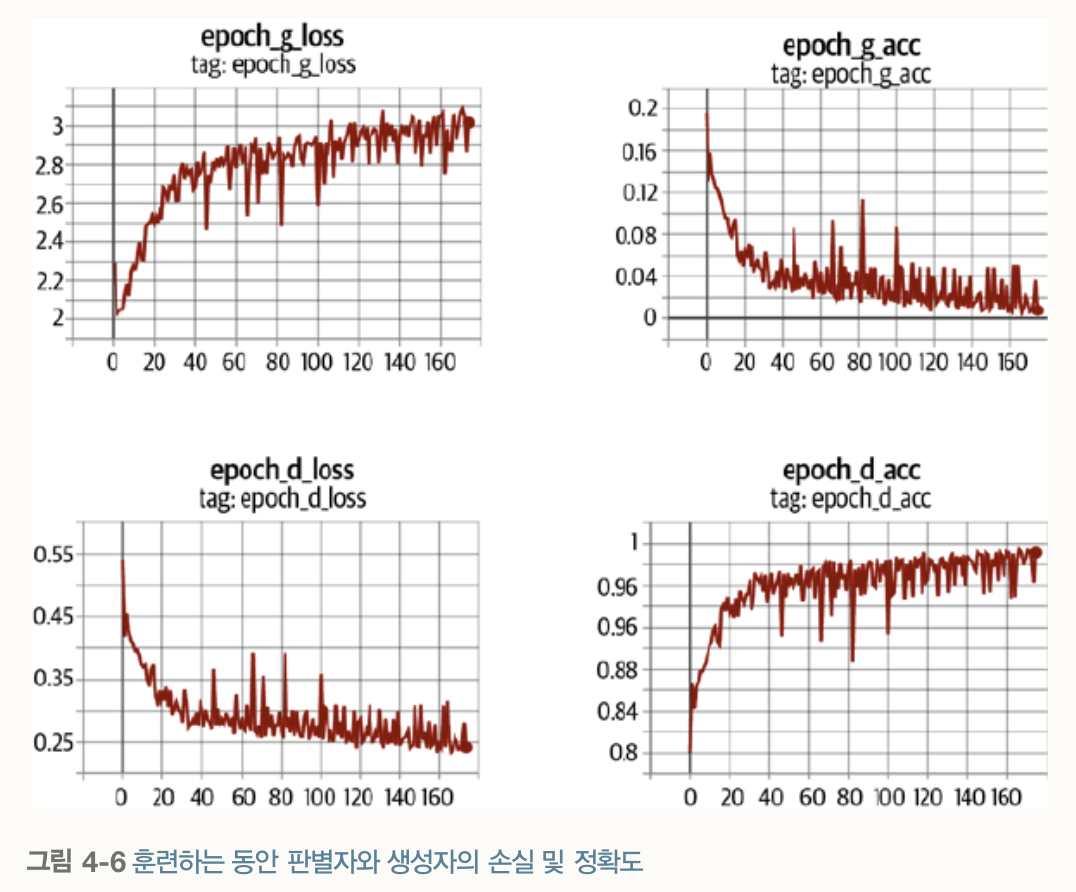

- 판별자와 생성자가 우위를 차지하려고 끊임없이 경쟁하기에 훈련 과정이 불안정
- => 생성자가 판별자에서 의미 있는 정보를 학습하는 균형점을 찾으면 이미지 품질이 향상되기 시작
- 충분한 시간이 지나면 판별자가 우세해지는 경향이 있으나 이미 생성자가 충분히 고품질 이미지를 생성하는 방법을 학습하여 문제 X

#### **레이블 평활화**
- 레이블에 잡음 추가
- 잡음 소량 추가 시 훈련 과정의 안정성이 개선되고 이미지를 선명하게 생성 가능
- 판별자가 풀어야 할 과제가 더 어려워져서 생성자를 과도하게 압도 못함

In [19]:
# DCGAN 생성
dcgan = DCGAN(
    discriminator=discriminator, generator=generator, latent_dim=Z_DIM
)

In [20]:
if LOAD_MODEL:
    dcgan.load_weights("./checkpoint/checkpoint.weights.h5")

## 3. GAN 훈련

In [21]:
# 컴파일 메서드를 호출하여 판별자와 생성자에 각각 최적화 함수(Adam)을 설정하는 부분
dcgan.compile(
    d_optimizer=optimizers.Adam(
        learning_rate=LEARNING_RATE, beta_1=ADAM_BETA_1, beta_2=ADAM_BETA_2
    ),
    g_optimizer=optimizers.Adam(
        learning_rate=LEARNING_RATE, beta_1=ADAM_BETA_1, beta_2=ADAM_BETA_2
    ),
)

# optimizers.Adam : 최적화 알고리즘 / 학습 속도를 조절하며 그레이디언트의 1차 모멘트와 2차 모멘트를 추적하는 방식으로 파라미터 업데이트
# learning_rate : 학습률 / 모델의 가중치 업데이트 속도 결정
# beta_1 = ADAM_BETA_1 : 1차 모멘트 추정치의 지수 감소율 / 일반적으로 0.9로 설정 => 그레이디언트의 기울기 추적에 사용
# beta_2 = ADAM_BETA_2 : 2차 모멘트 추정치의 지수 감소율 / 일반적으로 0.999로 설정 => 그레이디언트의 변화량 추적에 사용

In [22]:
# 모델 저장 체크포인트 만들기
# ModelCheckpoint : 학습 중간에 모델의 가중치를 저장하는 콜백
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./checkpoint/checkpoint.weights.h5",
    save_weights_only=True, # 모델 전체가 아닌 가중치만 저장
    save_freq="epoch", # 매 에포크가 끝날 때마다 가중치 저장
    verbose=0, # 저장시 출력되는 로그 생략
)

# TensorBoard : 학습 중의 로그와 메트릭을 시각화하는 도구
tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")

In [23]:
# 이미지 생성 콜백 클래스
class ImageGenerator(callbacks.Callback):
    def __init__(self, num_img, latent_dim):
        self.num_img = num_img # 한 번에 생성할 이미지의 개수 정의
        self.latent_dim = latent_dim # 생성자에 입력될 잠재 공간 벡터의 차원을 정의

    # 에포크 종료 시 이미지 생성
    def on_epoch_end(self, epoch, logs=None): # 에포크가 끝날 때마다 호출
        if epoch % 10 == 0: # 출력 횟수를 줄이기 위해 10 에포크마다 이미지 생성
            random_latent_vectors = tf.random.normal(
                shape=(self.num_img, self.latent_dim)
            )
            generated_images = self.model.generator(random_latent_vectors) # 생성자로부터 이미지를 생성한 후
            generated_images = generated_images * 127.5 + 127.5 # [-1, 1] 범위를 [0, 255] 범위로 변환
            generated_images = generated_images.numpy()
            display(
                generated_images,
                save_to="./output/generated_img_%03d.png" % (epoch),
            ) # 이미지를 화면에 표시 & 파일 저장

## 3. 새로운 이미지 생성

Epoch 1/100


  0%|          | 4.19M/1.07G [21:00<88:56:53, 3.33kB/s]


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step - d_acc: 0.9011 - d_fake_acc: 0.8970 - d_loss: 0.0100 - d_real_acc: 0.9053 - g_acc: 0.1030 - g_loss: 7.6444
Saved to ./output/generated_img_000.png


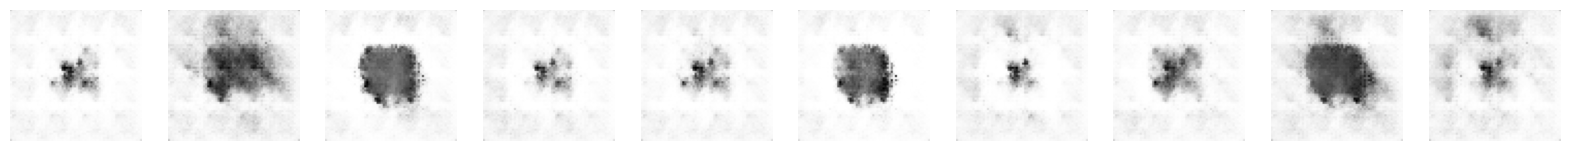

313/313 ━━━━━━━━━━━━━━━━━━━━ 130s 322ms/step - d_acc: 0.9011 - d_fake_acc: 0.8970 - d_loss: 0.0103 - d_real_acc: 0.9052 - g_acc: 0.1030 - g_loss: 7.6394
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 119s 323ms/step - d_acc: 0.9110 - d_fake_acc: 0.9199 - d_loss: 0.0271 - d_real_acc: 0.9022 - g_acc: 0.0801 - g_loss: 5.2458
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 125s 270ms/step - d_acc: 0.9337 - d_fake_acc: 0.9388 - d_loss: -0.1573 - d_real_acc: 0.9287 - g_acc: 0.0612 - g_loss: 7.0300
Epoch 4/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 158s 321ms/step - d_acc: 0.8641 - d_fake_acc: 0.8756 - d_loss: 0.4135 - d_real_acc: 0.8527 - g_acc: 0.1244 - g_loss: 6.0459
Epoch 5/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 92s 293ms/step - d_acc: 0.8896 - d_fake_acc: 0.8905 - d_loss: 0.0668 - d_real_acc: 0.8886 - g_acc: 0.1095 - g_loss: 5.5975
Epoch 6/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 87s 276ms/step - d_acc: 0.8934 - d_fake_acc: 0.8952 - d_loss: 0.1032 - d_real_acc: 0.8916 - g_acc: 0.1048 - g_loss: 4.5228
Epoch 7/100
313/313 ━━━

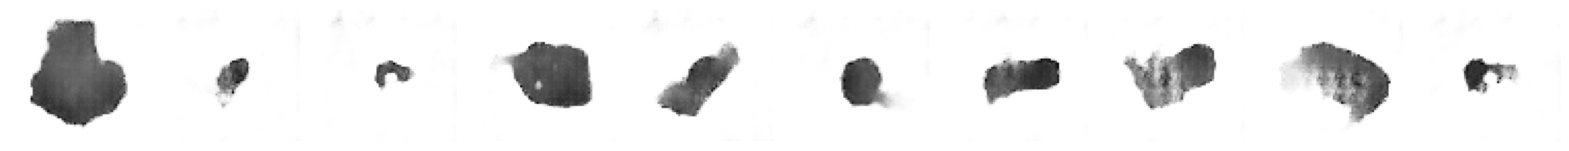

313/313 ━━━━━━━━━━━━━━━━━━━━ 79s 249ms/step - d_acc: 0.8934 - d_fake_acc: 0.8941 - d_loss: 0.0566 - d_real_acc: 0.8928 - g_acc: 0.1059 - g_loss: 5.4120
Epoch 12/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 84s 255ms/step - d_acc: 0.9172 - d_fake_acc: 0.9173 - d_loss: -0.0022 - d_real_acc: 0.9171 - g_acc: 0.0827 - g_loss: 5.7208
Epoch 13/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 82s 255ms/step - d_acc: 0.8543 - d_fake_acc: 0.8571 - d_loss: 0.2247 - d_real_acc: 0.8515 - g_acc: 0.1429 - g_loss: 5.3523
Epoch 14/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 81s 252ms/step - d_acc: 0.9172 - d_fake_acc: 0.9255 - d_loss: 0.0144 - d_real_acc: 0.9089 - g_acc: 0.0745 - g_loss: 5.9483
Epoch 15/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 83s 255ms/step - d_acc: 0.9179 - d_fake_acc: 0.9187 - d_loss: 0.0019 - d_real_acc: 0.9170 - g_acc: 0.0813 - g_loss: 6.2445
Epoch 16/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 83s 260ms/step - d_acc: 0.9300 - d_fake_acc: 0.9304 - d_loss: -0.0537 - d_real_acc: 0.9296 - g_acc: 0.0696 - g_loss: 6.2519
Epoch 17/100
313/313 

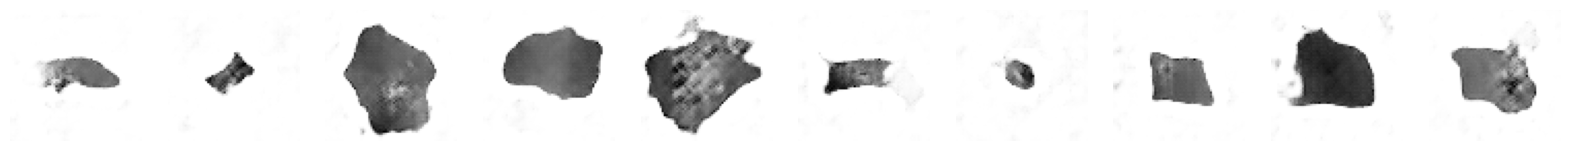

313/313 ━━━━━━━━━━━━━━━━━━━━ 84s 258ms/step - d_acc: 0.9150 - d_fake_acc: 0.9173 - d_loss: -0.0248 - d_real_acc: 0.9126 - g_acc: 0.0827 - g_loss: 6.8228
Epoch 22/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 79s 251ms/step - d_acc: 0.8729 - d_fake_acc: 0.8726 - d_loss: 0.0929 - d_real_acc: 0.8732 - g_acc: 0.1274 - g_loss: 5.8350
Epoch 23/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 81s 249ms/step - d_acc: 0.9408 - d_fake_acc: 0.9416 - d_loss: -0.1271 - d_real_acc: 0.9399 - g_acc: 0.0584 - g_loss: 7.1964
Epoch 24/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 85s 259ms/step - d_acc: 0.9415 - d_fake_acc: 0.9418 - d_loss: -0.1055 - d_real_acc: 0.9412 - g_acc: 0.0582 - g_loss: 7.3009
Epoch 25/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 81s 256ms/step - d_acc: 0.9276 - d_fake_acc: 0.9276 - d_loss: -0.1319 - d_real_acc: 0.9275 - g_acc: 0.0724 - g_loss: 7.5495
Epoch 26/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 81s 254ms/step - d_acc: 0.9471 - d_fake_acc: 0.9475 - d_loss: -0.1382 - d_real_acc: 0.9468 - g_acc: 0.0525 - g_loss: 7.4912
Epoch 27/100
313/3

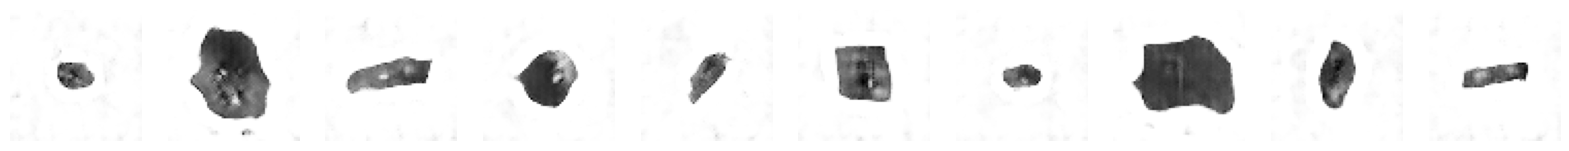

313/313 ━━━━━━━━━━━━━━━━━━━━ 137s 255ms/step - d_acc: 0.9512 - d_fake_acc: 0.9541 - d_loss: -0.2002 - d_real_acc: 0.9484 - g_acc: 0.0459 - g_loss: 8.2398
Epoch 32/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 84s 260ms/step - d_acc: 0.9311 - d_fake_acc: 0.9289 - d_loss: -0.1319 - d_real_acc: 0.9334 - g_acc: 0.0711 - g_loss: 7.4064
Epoch 33/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 82s 260ms/step - d_acc: 0.9222 - d_fake_acc: 0.9232 - d_loss: -0.0031 - d_real_acc: 0.9212 - g_acc: 0.0768 - g_loss: 7.7858
Epoch 34/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 79s 252ms/step - d_acc: 0.9625 - d_fake_acc: 0.9632 - d_loss: -0.2870 - d_real_acc: 0.9619 - g_acc: 0.0368 - g_loss: 8.5450
Epoch 35/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 82s 260ms/step - d_acc: 0.9374 - d_fake_acc: 0.9418 - d_loss: -0.1564 - d_real_acc: 0.9329 - g_acc: 0.0582 - g_loss: 8.0172
Epoch 36/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 78s 250ms/step - d_acc: 0.9772 - d_fake_acc: 0.9768 - d_loss: -0.4680 - d_real_acc: 0.9775 - g_acc: 0.0232 - g_loss: 10.9314
Epoch 37/100
31

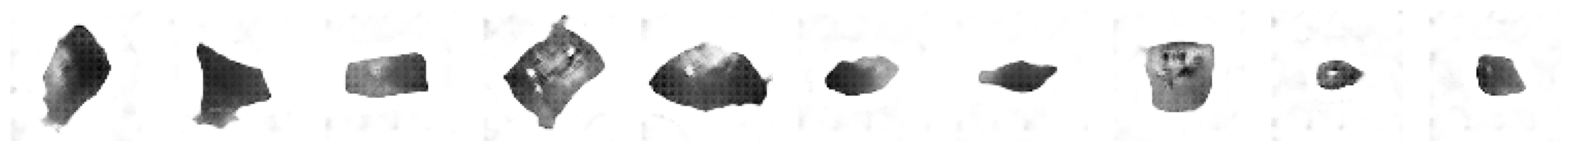

313/313 ━━━━━━━━━━━━━━━━━━━━ 85s 273ms/step - d_acc: 0.9382 - d_fake_acc: 0.9392 - d_loss: -0.1562 - d_real_acc: 0.9373 - g_acc: 0.0608 - g_loss: 8.5243
Epoch 42/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 84s 269ms/step - d_acc: 0.9266 - d_fake_acc: 0.9312 - d_loss: -0.0802 - d_real_acc: 0.9221 - g_acc: 0.0688 - g_loss: 9.1943
Epoch 43/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 79s 253ms/step - d_acc: 0.8557 - d_fake_acc: 0.8836 - d_loss: 0.8377 - d_real_acc: 0.8279 - g_acc: 0.1164 - g_loss: 8.8399
Epoch 44/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 84s 258ms/step - d_acc: 0.9381 - d_fake_acc: 0.9412 - d_loss: -0.1697 - d_real_acc: 0.9351 - g_acc: 0.0588 - g_loss: 8.4055
Epoch 45/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 82s 259ms/step - d_acc: 0.9317 - d_fake_acc: 0.9343 - d_loss: -0.1167 - d_real_acc: 0.9291 - g_acc: 0.0657 - g_loss: 9.1775
Epoch 46/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 81s 255ms/step - d_acc: 0.9526 - d_fake_acc: 0.9524 - d_loss: -0.2451 - d_real_acc: 0.9527 - g_acc: 0.0476 - g_loss: 10.3021
Epoch 47/100
313/

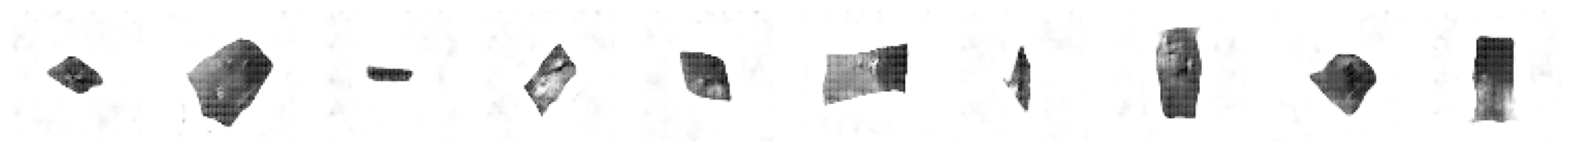

313/313 ━━━━━━━━━━━━━━━━━━━━ 82s 255ms/step - d_acc: 0.9837 - d_fake_acc: 0.9862 - d_loss: -0.6233 - d_real_acc: 0.9811 - g_acc: 0.0138 - g_loss: 14.2198
Epoch 52/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 83s 257ms/step - d_acc: 0.9997 - d_fake_acc: 0.9997 - d_loss: -0.7870 - d_real_acc: 0.9996 - g_acc: 2.5871e-04 - g_loss: 15.8079
Epoch 53/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 80s 253ms/step - d_acc: 1.0000 - d_fake_acc: 1.0000 - d_loss: -0.8013 - d_real_acc: 1.0000 - g_acc: 0.0000e+00 - g_loss: 16.1177
Epoch 54/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 81s 251ms/step - d_acc: 1.0000 - d_fake_acc: 1.0000 - d_loss: -0.8007 - d_real_acc: 1.0000 - g_acc: 0.0000e+00 - g_loss: 16.1174
Epoch 55/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 82s 252ms/step - d_acc: 1.0000 - d_fake_acc: 1.0000 - d_loss: -0.8024 - d_real_acc: 1.0000 - g_acc: 0.0000e+00 - g_loss: 16.1175
Epoch 56/100
 69/313 ━━━━━━━━━━━━━━━━━━━━ 1:00 246ms/step - d_acc: 1.0000 - d_fake_acc: 1.0000 - d_loss: -0.7978 - d_real_acc: 1.0000 - g_acc: 0.0000e+00 - g_loss

In [ ]:
dcgan.fit(
    train,
    epochs=EPOCHS,
    callbacks=[
        model_checkpoint_callback,
        tensorboard_callback, # 학습 도중 발생하는 로그와 메트릭 기록 / 학습 과정의 손실, 정확도 등의 변화를 시각적으로 확인 가능
        ImageGenerator(num_img=10, latent_dim=Z_DIM), # 10개의 이미지를 생성 / latent_dim : 잠재공간의 차원으로 설정
    ],
)

In [1]:
# 표준 정규 분포에서 잠재 공간의 일부 포인트 샘플링
grid_width, grid_height = (10, 3) # 샘플링 할 잠재 공간의 포인트 개수 정의
z_sample = np.random.normal(size=(grid_width * grid_height, Z_DIM)) # 10 * 3 = 30개 잠재 벡터를 샘플링
# np.random.normal : 표준 정규 분포에서 무작위 값 생성
# 각 잠재 벡터의 차원은 Z_DIM : 잠재 공간의 차원

NameError: name 'np' is not defined

In [2]:
# 샘플링된 포인트 디코딩
reconstructions = generator.predict(z_sample) # 샘플링된 잠재 벡터를 사용해 생성자를 통해 이미지를 디코딩(복원)하는 작업

NameError: name 'generator' is not defined

In [ ]:
# 디코딩된 이미지 그리기
fig = plt.figure(figsize=(18, 5))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

# 얼굴 그리드 출력
for i in range(grid_width * grid_height): # 30개의 이미지 처리
    ax = fig.add_subplot(grid_height, grid_width, i + 1) # 현재의 i 값에 따라 새로운 서브플롯 추가
    ax.axis("off")
    ax.imshow(reconstructions[i, :, :], cmap="Greys") # reconstructions 배열에서 i 번째 이미지 시각화

#### 두 이미지 사이의 거리를 재는 방법 (L1 노름(norm))
- 생성된 이미지와 가장 비슷한 훈련 세트의 샘플

In [3]:
def compare_images(img1, img2):
    return np.mean(np.abs(img1 - img2)) # 두 이미지 간의 평균 픽셀 차이를 반환 => 값이 작을수록 유사함

In [6]:
all_data = []
for i in train.as_numpy_iterator():
    all_data.extend(i)
all_data = np.array(all_data) # 훈련 데이터셋의 모든 요소를 포함하는 Numpy 배열

NameError: name 'train' is not defined

In [5]:
# 생성된 이미지를 그리드 형태로 시각화하는 과정

r, c = 3, 5 # 3행 5열, 총 15개의 이미지 출력
fig, axs = plt.subplots(r, c, figsize=(10, 6))
fig.suptitle("Generated images", fontsize=20)

# 생성할 이미지의 잠재 공간(latent space)에서 랜덤 노이즈 벡터 생성
noise = np.random.normal(size=(r * c, Z_DIM)) # 15개의 노이즈 벡터 생성 & 벡터의 크기 Z_DIM
gen_imgs = generator.predict(noise) # 생성자 모델을 사용해 노이즈 벡터로부터 이미지 생성

cnt = 0
for i in range(r):
    for j in range(c):
        axs[i, j].imshow(gen_imgs[cnt], cmap="gray_r")
        axs[i, j].axis("off")
        cnt += 1

plt.show()

NameError: name 'plt' is not defined

In [ ]:
# 생성된 이미지들과 훈련 데이터셋에서 가장 유사한 이미지를 찾아 시각화하는 과정

fig, axs = plt.subplots(r, c, figsize=(10, 6))
fig.suptitle("Closest images in the training set", fontsize=20)

cnt = 0
for i in range(r):
    for j in range(c):
        c_diff = 99999 # 가장 작은 차이를 저장할 변수 초기화
        c_img = None # 현재 가장 유사한 이미지를 저장할 변수 초기화
        for k_idx, k in enumerate(all_data): # k_idx : 인데스 / k : 현재 이미지
            diff = compare_images(gen_imgs[cnt], k) # 생성된 이미지와 현재 훈련 데이터 이미지간의 차이
            if diff < c_diff:
                c_img = np.copy(k) # 가장 유사한 이미지로 업데이트
                c_diff = diff # 가장 작은 차이 값 업데이트
        axs[i, j].imshow(c_img, cmap="gray_r")
        axs[i, j].axis("off")
        cnt += 1

plt.show()

### GAN 훈련 팁과 트릭
1. **판별자가 생성자보다 뛰어난 경우**
- 판별자를 약화할 방법 찾기
- => 판별자 Dropout 층의 rate 매개 변수값 증가시켜 흐르는 정보 양 줄이기
- => 판별자의 학습률 줄이기
- => 판별자의 합성곱 필터 수 줄이기
- 판별자 훈련 시 레이블 잡음 추가
- 판별자 훈련 시 일부 이미지 레이블을 무작위로 뒤집기  
  
2. **생성자가 판별자보다 강한 경우**
- 판별자가 강력하지 않을 때 생성자가 거의 동일한 이미지로 판별자를 쉽게 속임 => **모드 붕괴**

3. **유용하지 않은 손실**
- 생성자는 현재 판별자에 의해서만 평가되고 판별자는 계속 향상되기에 훈련 과정의 다른 지점에서의 평가된 손실을 비교할 수 없다.
- 생성자의 손실과 이미지 품질 사이의 연관성 부족은 GAN 훈련 과정을 모니터링하기 어렵게 한다.

4. **하이퍼파라미터**
- GAN은 튜닝해야 할 하이퍼파라미터의 개수가 상당히 많다
- 판별자와 생성자의 구조 뿐만 아니라, 배치 정규화, 드롭아웃, 학습률, 활성화 층, 합성곱 필터, 커널 크기, 스트라이드, 배치 크기, 잠재 공간 크기를 결정하는 하이퍼파라미터를 고려해야 한다.